# Get feature importance / SHAP values

In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as pl
import ml_help
from time import time
import seaborn as sns
sns.set_theme()

/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def d

In [5]:
df = pd.read_csv("./data/yonge_count.csv.zip")
df.drop(["location", "time"], axis=1, inplace=True)
df.rename({
    "hour": "Hour",
    "minute": "Minute",
    "month": "Month",
    "day": "Day",
    "day_of_week": "Weekday",
    "dist_from_mid_point": "Dist. Mid. Point",
    "is_north_from_mid_point": "North of Mid. Point"
}, axis=1, inplace=True)
df

,total_count,Hour,Minute,Month,Day,Weekday,Dist. Mid. Point,North of Mid. Point
0,984,7,45,March,3,Tuesday,3.499076,1
1,1046,8,0,March,3,Tuesday,3.499076,1
2,1034,8,15,March,3,Tuesday,3.499076,1
3,1032,8,30,March,3,Tuesday,3.499076,1
4,934,8,45,March,3,Tuesday,3.499076,1
...,...,...,...,...,...,...,...,...
8379,468,17,0,August,24,Wednesday,0.243920,1
8380,478,17,15,August,24,Wednesday,0.243920,1
8381,422,17,30,August,24,Wednesday,0.243920,1
8382,436,17,45,August,24,Wednesday,0.243920,1


In [6]:
categorical_feats = ["Month","Weekday"]

transformed_df = pd.get_dummies(df, columns=categorical_feats, prefix="", prefix_sep="")
transformed_df = transformed_df.astype("float32")
transformed_df

,total_count,Hour,Minute,Day,Dist. Mid. Point,North of Mid. Point,April,August,December,February,...,July,June,March,May,October,September,Saturday,Thursday,Tuesday,Wednesday
0,984.0,7.0,45.0,3.0,3.499076,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1046.0,8.0,0.0,3.0,3.499076,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1034.0,8.0,15.0,3.0,3.499076,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1032.0,8.0,30.0,3.0,3.499076,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,934.0,8.0,45.0,3.0,3.499076,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,468.0,17.0,0.0,24.0,0.243920,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8380,478.0,17.0,15.0,24.0,0.243920,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8381,422.0,17.0,30.0,24.0,0.243920,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8382,436.0,17.0,45.0,24.0,0.243920,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
X = transformed_df.drop("total_count",axis=1)
y = transformed_df["total_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.80 = 0.20

# XGBoost

Fitting...
Fitting... OK! Took 1.00649094581604 seconds
Explaining...
Explaining... OK! Took 0.9407882690429688 seconds
Calculating shap values...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Calculating shap values... OK! Took 0.9393634796142578 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


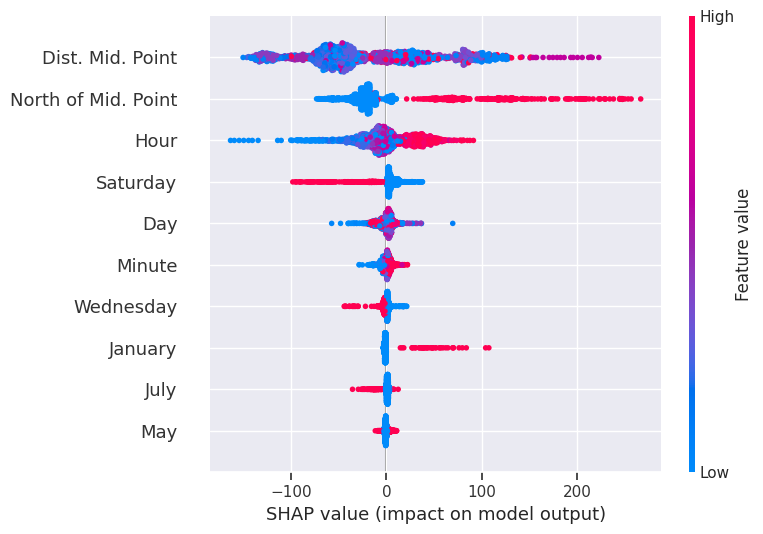

In [8]:
import xgboost as xgb

params = ml_help.params_to_dict("033_xgboost")
params["predictor"] = "cpu_predictor"
params["tree_method"] = "hist"
model = xgb.XGBRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
xgboost_fig = pl.gcf()
pl.savefig("./plots/036_xgboost.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/036_xgboost.png", bbox_inches="tight")
pl.savefig("./plots/036_xgboost.pdf", bbox_inches="tight")

# Random Forest

Fitting...
Fitting... OK! Took 1.1095333099365234 seconds
Explaining...
Explaining... OK! Took 0.008984804153442383 seconds
Calculating shap values...
Calculating shap values... OK! Took 4.140565633773804 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


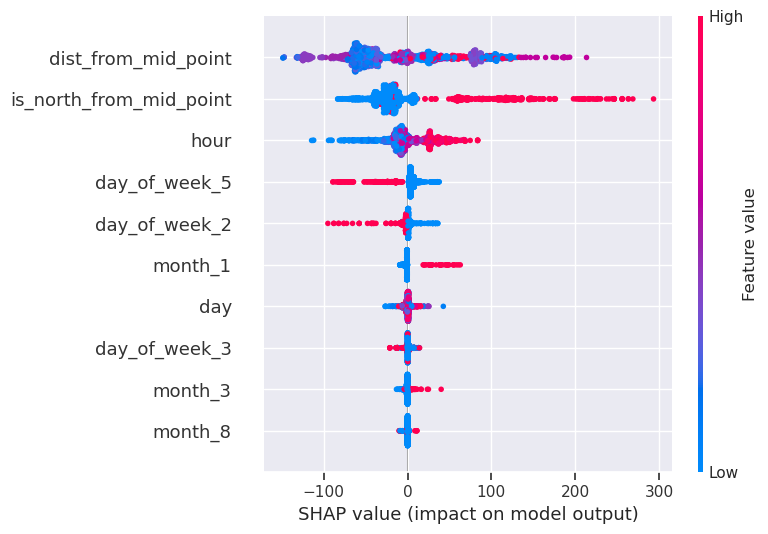

In [6]:
from sklearn.ensemble import RandomForestRegressor

params = ml_help.params_to_dict("033_random_forest")
model = RandomForestRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/036_random_forest.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/036_random_forest.png", bbox_inches="tight")

# Decision Tree

Fitting...
Fitting... OK! Took 0.007908821105957031 seconds
Explaining...
Explaining... OK! Took 0.0007448196411132812 seconds
Calculating shap values...
Calculating shap values... OK! Took 0.018843650817871094 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


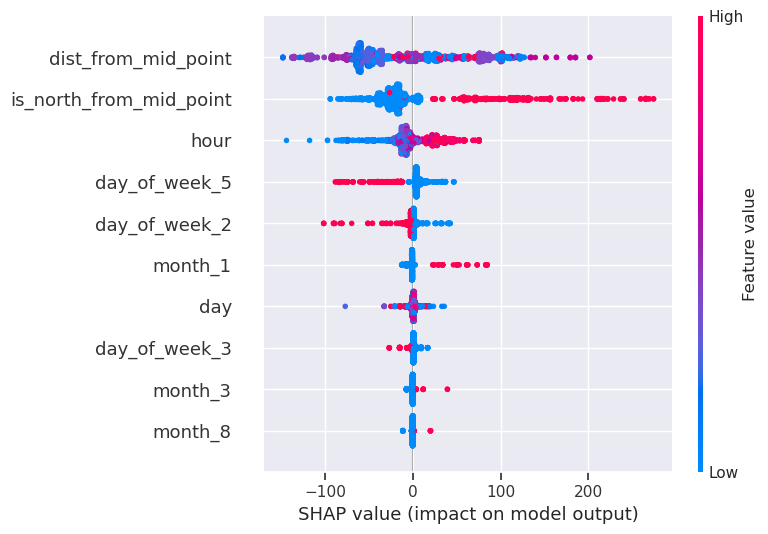

In [7]:
from sklearn.tree import DecisionTreeRegressor

params = ml_help.params_to_dict("033_decision_tree")
model = DecisionTreeRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/036_decision_tree.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/036_decision_tree.png", bbox_inches="tight")

# MLP

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Fitting...
Fitting... OK! Took 21.636404037475586 seconds
Explaining...
Explaining... OK! Took 0.0005645751953125 seconds
Calculating shap values...


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
X does not have valid feature names, but MLPRegressor was fitted with feature names


  0%|          | 0/1677 [00:00<?, ?it/s]

Calculating shap values... OK! Took 42.747493743896484 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


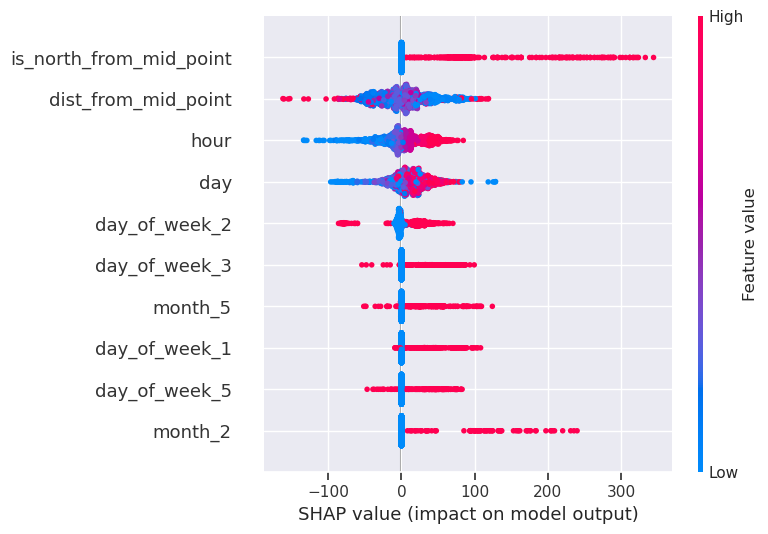

In [8]:
from sklearn.neural_network import MLPRegressor
import warnings

X_train_summary = shap.kmeans(X_train, 10)

params = ml_help.params_to_dict("033_mlpr")
model = MLPRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.KernelExplainer(model.predict, X_train_summary)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/036_mlp.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/036_mlp.png", bbox_inches="tight")